In [2]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from project_modules.io import load_dataset_to_df
from project_modules.classifcation import classify_MP,getXY, boruta_fs
from project_modules.utils import MPutils
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.model_selection import cross_val_score
import cupy as cp
from datetime import datetime

from tqdm.notebook import tqdm
from copy import deepcopy

import umap
import matplotlib.colors as mc

import colorcet as cc
from sklearn.pipeline import Pipeline
# clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
# from project_modules.utils import get_logger
# logger = get_logger("log-data-combine-split.log")
# # read the parameter file

# from project_modules.utils import read_parameters
# parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

In [3]:
lScorersBinary = [
    "accuracy",
    "balanced_accuracy",
    "roc_auc",
    "f1",
    "recall",
    "sensitivity",
    "specificity",
    "precision",
    # "average_precision",
    "NPV",
    "PPV",
    # "neg_mean_squared_error",
]
lResCol = [
    "Title",
    "cv",
    "param_clf",
    "param_clf__max_depth",
    "param_clf__n_estimators",
    "param_clf__random_state",
    # "param_clf__max_iter",
    "mean_test_accuracy",
    "mean_test_balanced_accuracy",
    "mean_test_roc_auc",
    "mean_test_f1",
    "mean_test_recall",
    "mean_test_sensitivity",
    "mean_test_specificity",
    "mean_test_precision",
    "mean_test_NPV",
    "mean_test_PPV",
]

In [4]:
# lDataNames = ['T81','T85','DT']


lDataNames = [
    "dfcmpltPreLC4",  # LEFT
    "dfcmpltPreLC4_SITE1", # LEFT
    "dfcmpltPreLC4_SITE2", # LEFT
    "dfcmpltPreLC4_SITE3", # LEFT
    "dfcmpltPreLC4_SITE4", # LEFT
    "dfcmpltPreLC4_SITE5",  # LEFT
    "dfcmpltPreLC4_SITE6",  # LEFT
    "dfcmpltPreLC4_SITE7",  # LEFT
]
dataDir = "../Data/DataV3/TTS/"
saveDir = MPutils.get_saving_dir('OUTPUT/MP/05-classifiers-plot/')

In [5]:
site_name_dict = {1: "LDN", 2: "MTL", 3: "SAN", 4: "RIO", 5: "LUS", 6: "CA", 7: "NA"}
status_name_dict = {0: "HC", 1: "LC_NEG", 2: "LC_POS"}

In [6]:
# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}

# assign consistent styles
site_style = {
              1: 'D',
              2: 'o',
              3: 'P',
              4: 'X',
              5: 's',
}
nicefeat = pd.read_csv('OUTPUT/MP/niceFeatures.csv')
niceFeatDict = dict(zip(nicefeat['feature'], nicefeat['clean']))

ROC_AUC_Dict = {
1:0.921, #ldn
2:0.670, #mtl
3:0.899, #san
4:1.000, #rio
5:0.503, #lus
6:0.730, #can
7:0.786, #north am
}

In [7]:
import json
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

with open('JSON/selectFeaturePalette.json') as f: paletteSel = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeat.json') as f: paletteSel_NF = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeatFlipped.json') as f: paletteSel_NFF = json.load(f)

# Process data and run clustering

In [8]:
# globalfeat = 'FS_dfcmpltPreLC3_Boruta_T1000_itrr500_th100_topR5_MD3'
valSelTests = {
    # "dfcmpltPreLC3":[
    #     globalfeat
    # ],
    "dfcmpltPreLC4_SITE1":{
        'featlist':'FS_dfcmpltPreLC4_SITE1_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'London',
    },
    "dfcmpltPreLC4_SITE2":{
        'featlist':'FS_dfcmpltPreLC4_SITE2_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'Montreal',
    },
    "dfcmpltPreLC4_SITE3":{
        'featlist':'FS_dfcmpltPreLC4_SITE3_Boruta_T1000_itrr500_th100_topR5_MD7',
        'site':'San Diego',
    },
    "dfcmpltPreLC4_SITE4":{
        'featlist':'FS_dfcmpltPreLC4_SITE4_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'Rio',
    },
    "dfcmpltPreLC4_SITE5":{
        'featlist': 'FS_dfcmpltPreLC4_SITE5_Boruta_T1000_itrr500_th100_topR5_MD5',
        'site':'Lusaka'
    },
    "dfcmpltPreLC4_SITE6":{
        'featlist':'FS_dfcmpltPreLC4_SITE6_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'Canada',
    },
    "dfcmpltPreLC4_SITE7":{
        'featlist':'FS_dfcmpltPreLC4_SITE7_Boruta_T1000_itrr500_th100_topR5_MD3',
        'site':'NorthAmerica',
    },
}
valSelKeys = [
 'dfcmpltPreLC4_SITE1',
 'dfcmpltPreLC4_SITE2',
 'dfcmpltPreLC4_SITE3',
 'dfcmpltPreLC4_SITE4',
 'dfcmpltPreLC4_SITE5',
 'dfcmpltPreLC4_SITE6',
 'dfcmpltPreLC4_SITE7']

In [9]:
for selData in tqdm(valSelTests.keys(),desc='DataSet Main Outer Loop'):
    
    tmpDict = valSelTests[selData] # get site Dict
    selFeatName = tmpDict['featlist'] #get site feature file
    
    #load df
    df_h = load_dataset_to_df(f"{dataDir}{selData}_Holdout.arrow", verbose=True)
    
    df_h.drop(df_h[df_h["LC_STATUS"] == 2].index, inplace=True)  # drop HC
    
    #drop columns
    lColDrop = ["__index_level_0__", "LC_STATUS_SITE",'SITE']
    for c in lColDrop:
        if c in df_h.columns:
            df_h.drop(columns=[c], inplace=True)

    tmpDict['data'] = df_h #store data
    
    #init saving dir
    tmpDict['savedir'] = MPutils.get_saving_dir(
        f"OUTPUT/MP/05-classifiers/DataV3/{selData}/"
    )

    #get Sel Cols
    tmpDict['featDir']= selFeatName.replace('FS_','').split('_Boruta')[0]
    tmpDict['selCols']= MPutils.getTrueFeatList(f"OUTPUT/MP/05-classifiers/DataV3/{tmpDict['featDir']}/{selFeatName}.csv")
    
    #get x and y
    x_h, y_h = getXY(df_h)
    tmpDict['x_h']=x_h[tmpDict['selCols']]# select Boruta Cols and store
    tmpDict['y_h']=y_h #store labels


    tmpDict['impSite'] = pd.read_csv(f"OUTPUT/MP/05-classifiers/DataV3/{tmpDict['featDir']}/FR_{tmpDict['featDir']}_HoldoutVal_{selFeatName}.csv")
    
    for x in tmpDict['selCols']:
        if x not in nicefeat['feature'].values:
            raise Exception(f'Col {x} not in niceFeat')
    
    # # UMAP
    # umap_parms = {
    #                 'n_components': 2,
    #                 'spread':       20.0,
    #                 'random_state': 42,
    #                 'n_neighbors': int(tmpDict['x_h'].shape[0]*0.3),
    #                 'min_dist': 0.1
    #             }
    
    

    # # instantiate the pipeline
    # pipe = Pipeline([
    #                 # scale to unit size
    #                 ('scaler', MinMaxScaler()),
    #                 ('umap', umap.UMAP(**umap_parms, verbose = False)),
    #                 ])

    # pipeTrans= pipe.fit_transform(tmpDict['x_h']) #run pipeline for dataset
    
    # dfTrans = pd.DataFrame(pipeTrans) #convert to dataframe
    # dfTrans['LC'] = tmpDict['data']['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'}) #set LC column
    # tmpDict['umap'] = dfTrans #store umap dataset
    # tmpDict['umapRes'] = pipeTrans
    
    # # TSNE
    # tsne_parms = {
    #                 'n_components': 2,
    #                 'perplexity': 10.0,
    #                 'random_state': 42,
    #             }

    # # instantiate the pipeline
    # pipe = Pipeline([
    #                 # scale to unit size
    #                 ('scaler', MinMaxScaler()),
    #                 ('tsne', TSNE(**tsne_parms, verbose = False)),
    #                 ])

    # pipeTrans= pipe.fit_transform(tmpDict['x_h']) #run pipeline for dataset
    
    # dfTrans = pd.DataFrame(pipeTrans) #convert to dataframe
    # dfTrans['LC'] = tmpDict['data']['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'}) #set LC column
    # tmpDict['tsne'] = dfTrans #store umap dataset
    
    

DataSet Main Outer Loop:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
'age' in nicefeat['feature'].values

True

In [11]:
# lc = []
# for selData in tqdm(valSelTests.keys(),desc='DataSet Main Outer Loop'):
    
#     tmpDict = valSelTests[selData] # get site Dict
#     lc += tmpDict['selCols']

# UMAP indv site

## dfcmpltPreLC3_SITE1

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_658123/4060501097.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5, s=50) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

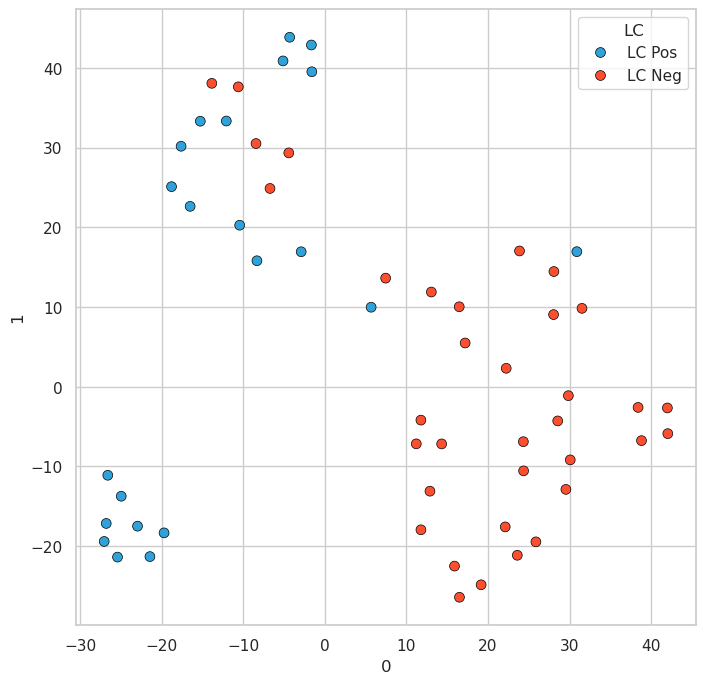

In [12]:
tmpDict = valSelTests['dfcmpltPreLC4_SITE1']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       15.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.15),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaked'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5, s=50) #ax=ax[splot]

## dfcmpltPreLC3_SITE2

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_658123/254221522.py:27: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1.0, edgecolor='black', linewidth=0.5, s=50) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

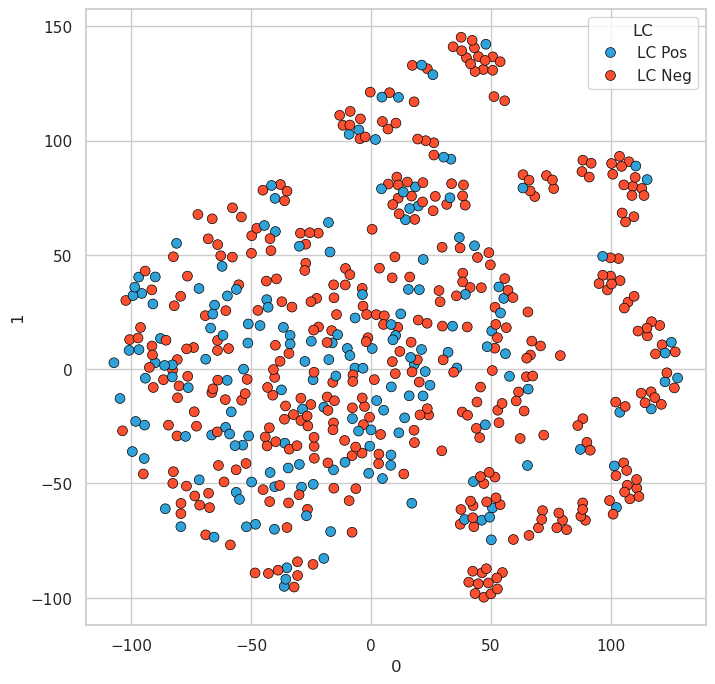

In [14]:
tmpDict = valSelTests['dfcmpltPreLC4_SITE2']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       75.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.15),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaked'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap
#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1.0, edgecolor='black', linewidth=0.5, s=50) #ax=ax[splot]

## dfcmpltPreLC3_SITE3

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_658123/4199068440.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

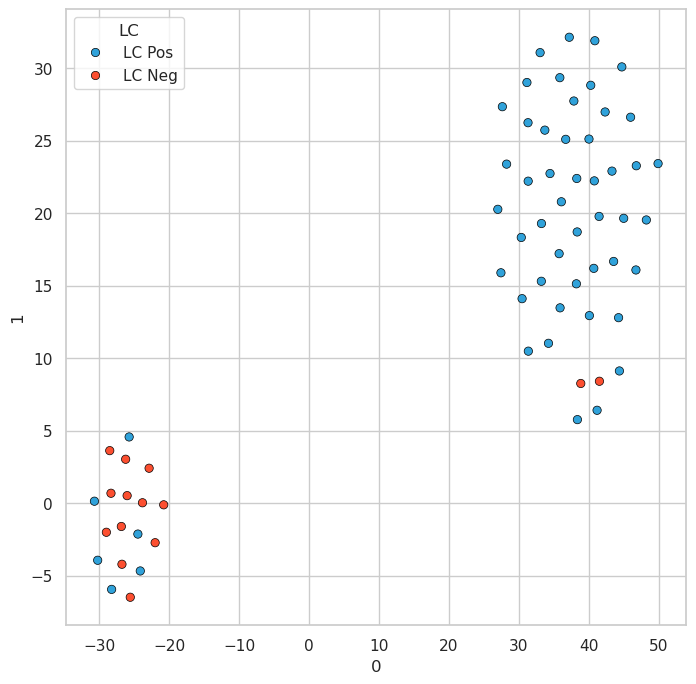

In [18]:
tmpDict = valSelTests['dfcmpltPreLC4_SITE3']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       10.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.15),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaked'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]

## dfcmpltPreLC3_SITE4

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_658123/2813091176.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

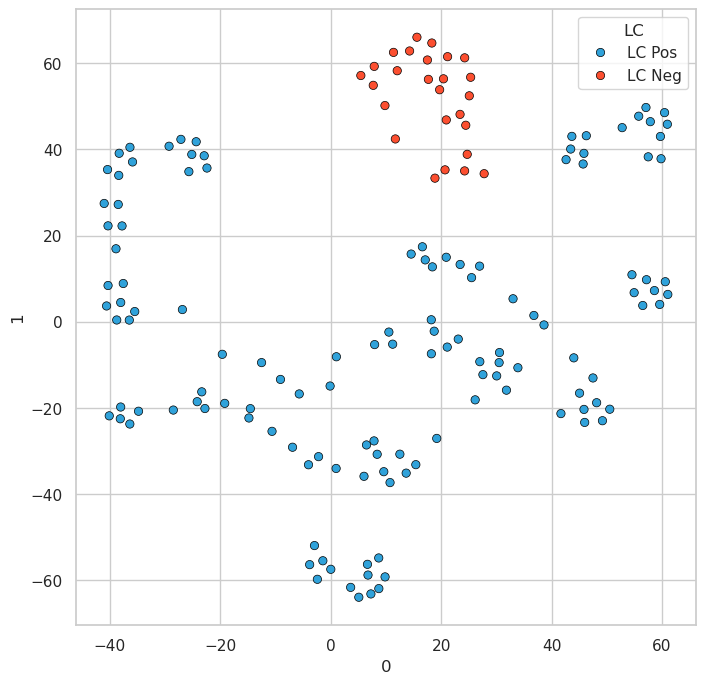

In [21]:
tmpDict = valSelTests['dfcmpltPreLC4_SITE4']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':      25.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.1),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaked'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_658123/745271845.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5,s=50) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

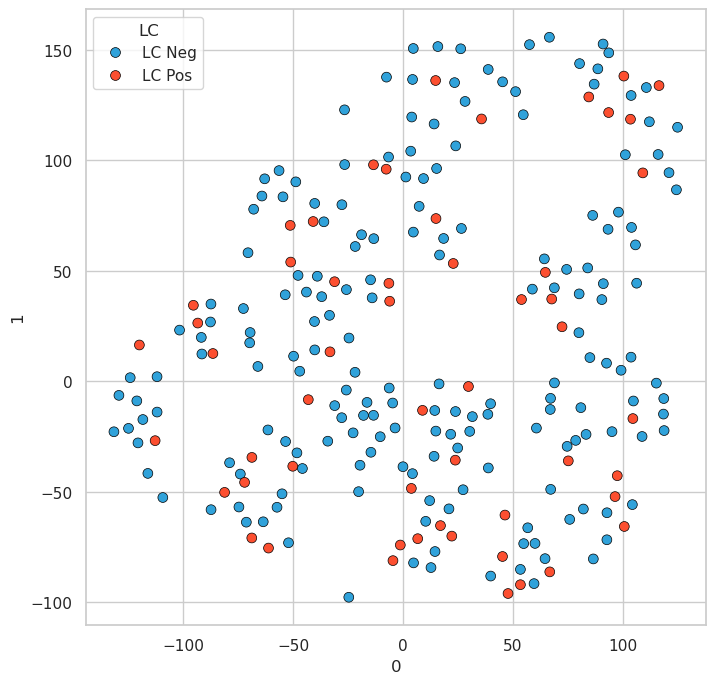

In [23]:
tmpDict = valSelTests['dfcmpltPreLC4_SITE5']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':      100.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.15),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaked'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5,s=50) #ax=ax[splot]

# UMAP Plot Site Based - all tegether - same params

In [22]:
# #go through sites and plot
# for i, splot in enumerate(sString.replace(';','')):
    
#     tmpDict = valSelTests[valSelKeys[i]] #get site dictionary

#     #plot umap
#     sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot], edgecolor='black', linewidth=0.5, s=50)
    
#     #setup plot
#     ax[splot].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     ax[splot].set_xticks([]); ax[splot].set_yticks([])
#     ax[splot].set_xlabel(""); ax[splot].set_ylabel("")
#     ax[splot].set_title(tmpDict['site'])
    
#     # umap.plot.points(tmpDict['umapRes'],labels=tmpDict['y_h'])

# plt.savefig(f'{saveDir}/Fig2-SiteSpecific/Fig2-SiteSpecific-UMAPonly.jpg', dpi=800, bbox_inches='tight', facecolor='white')

# UMAP and Feature Ranking Plot Site Based - all tegether - same params

In [25]:
tmpImp

,Rank,Feature,Importance,Relative Importance
0,1,Age,0.9242,1.000000
1,2,(LCov_Comp) Respiratory Unknown Origin,0.0758,0.082017


/tmp/ipykernel_658123/430153623.py:12: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot[0]], edgecolor='black', linewidth=0.5, s=50)
/tmp/ipykernel_658123/430153623.py:12: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot[0]], edgecolor='black', linewidth=0.5, s=50)
/tmp/ipykernel_658123/430153623.py:12: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot[0]], edgecolor='black', linewidth=0.5, s=50)
/tmp/ipykernel_658123/430153623.py:12: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplo

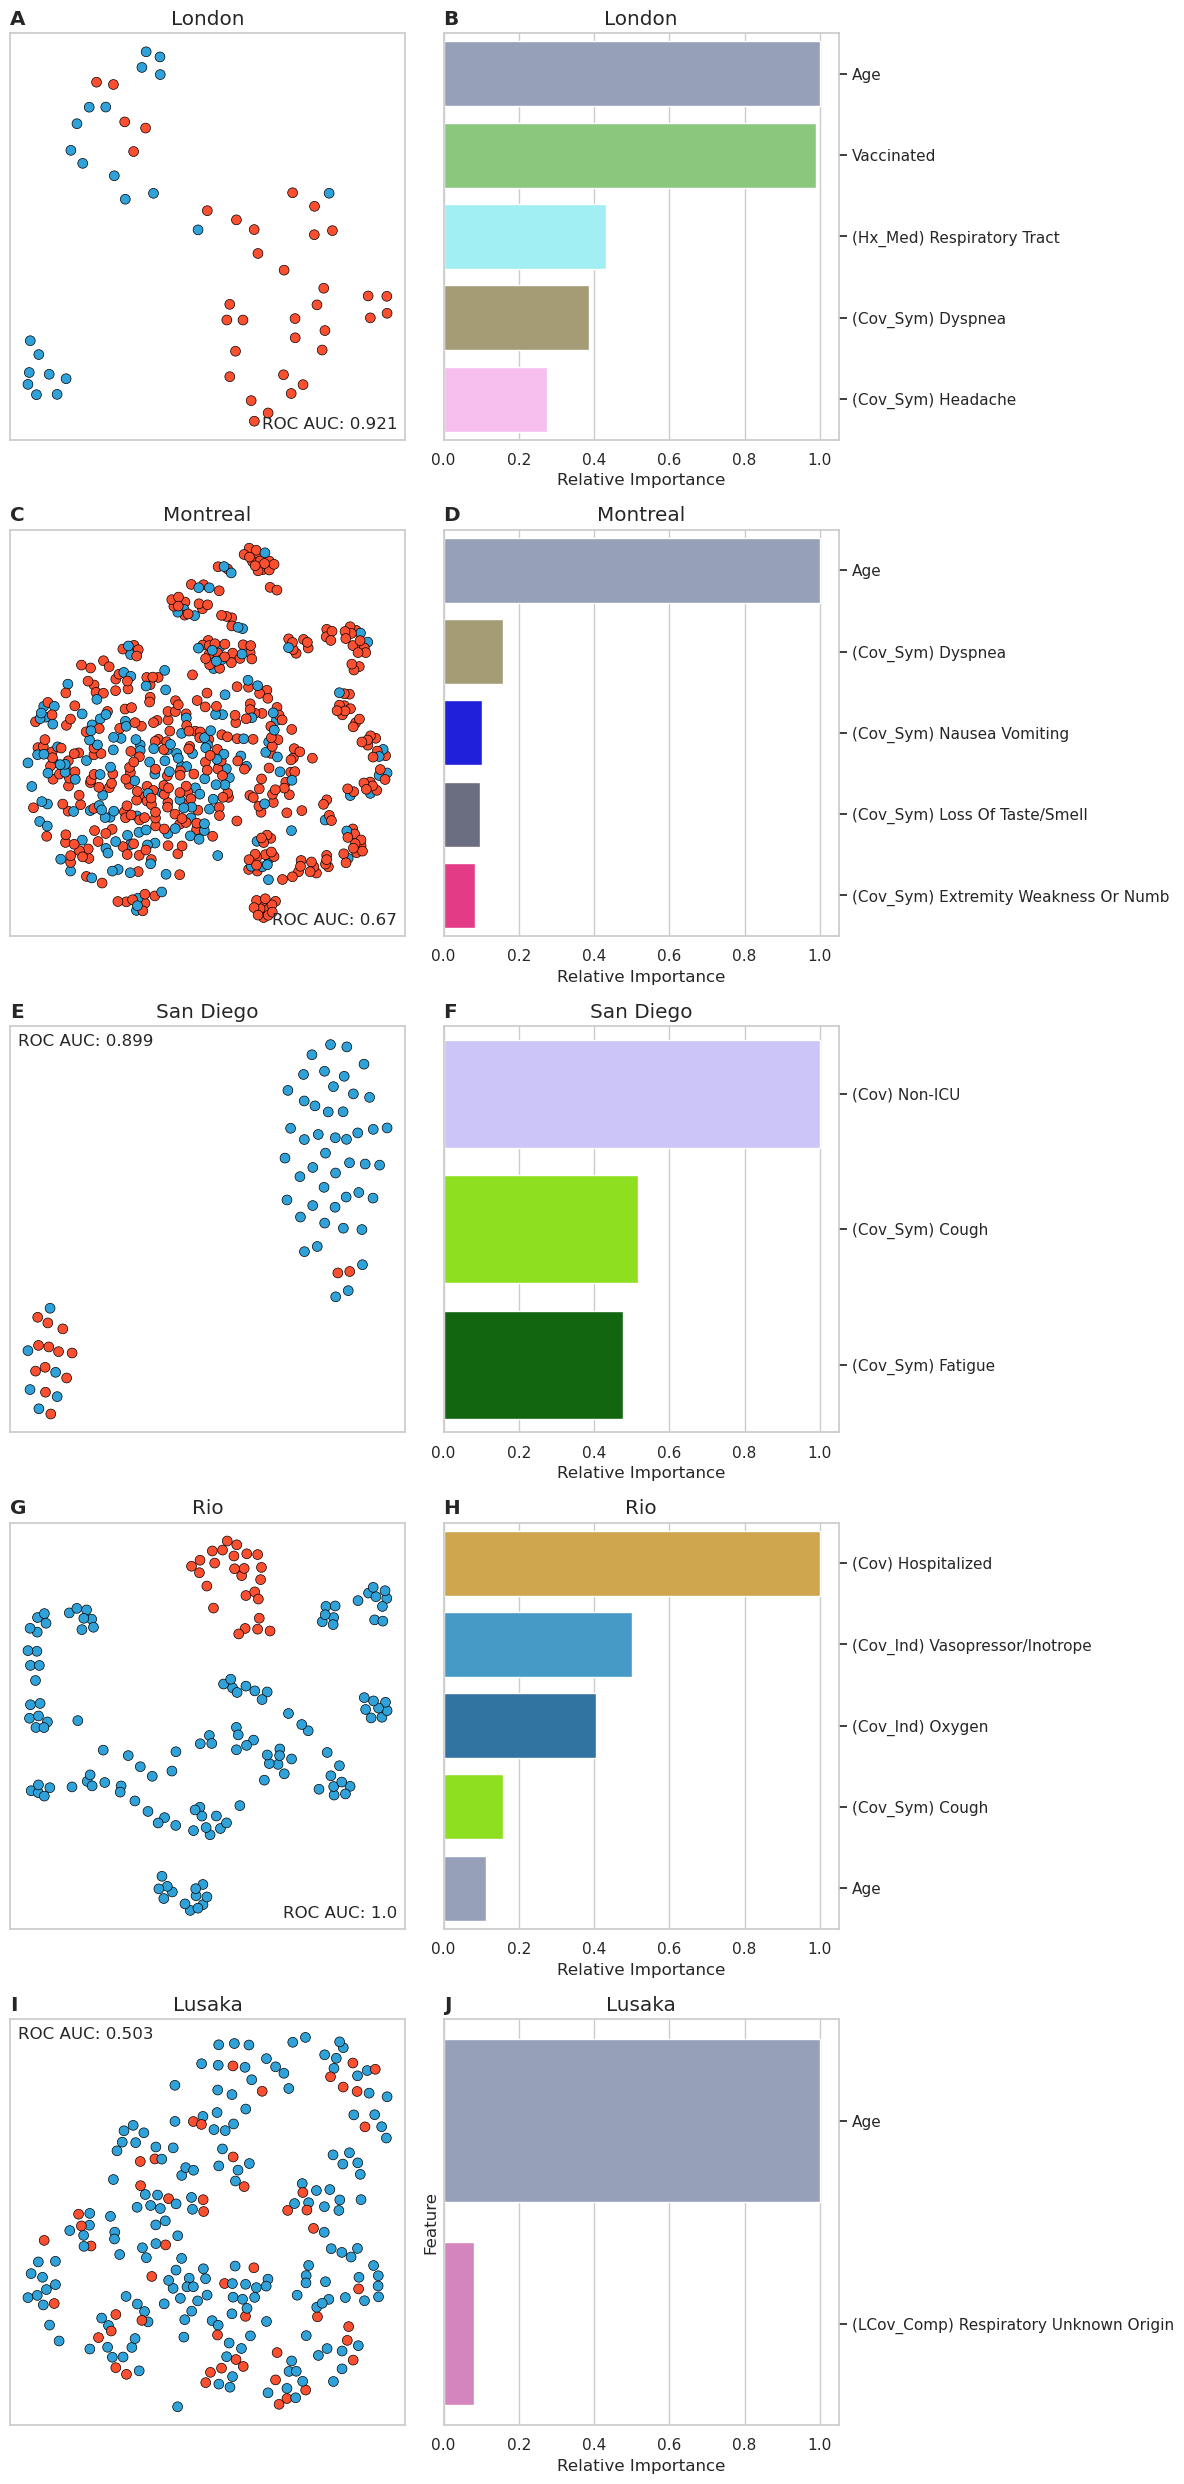

In [26]:
fontsizeSubplt = 'large'
fontsizeTitle = 'large'
sString = 'AB;CD;EF;GH;IJ'
fig, ax = plt.subplot_mosaic(sString,figsize=(12,25))

#go through sites and plot
for i, splot in enumerate(sString.split(';')):
    
    tmpDict = valSelTests[valSelKeys[i]] #get site dictionary

    #plot umap
    sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot[0]], edgecolor='black', linewidth=0.5, s=50)
    # sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot[1]], edgecolor='black', linewidth=0.5, s=50)
    

    tmpImp = deepcopy(tmpDict['impSite'])
    tmpImp['Relative Importance'] = tmpImp['Importance']/tmpImp['Importance'].max()
    tmpImp['Feature'] = tmpDict['impSite']['Feature'].map(niceFeatDict)
    
    
    sns.barplot(data=tmpImp.sort_values('Relative Importance',ascending=False).iloc[:5],x='Relative Importance',y='Feature',orient='h',ax=ax[splot[1]], palette=paletteSel_NF,hue='Feature')
    # ax.tick_params(axis='y', labelright=True, labelleft=False)
    ax[splot[1]].yaxis.tick_right()

    
    # #setup plot
    # ax[splot[0]].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[splot[0]].legend().set_visible(False)
    ax[splot[0]].set_xticks([]); ax[splot[0]].set_yticks([])
    ax[splot[0]].set_xlabel(""); ax[splot[0]].set_ylabel("")
    ax[splot[0]].set_title(tmpDict['site'], fontsize=fontsizeTitle)
    
    
    rauc = f'ROC AUC: {ROC_AUC_Dict[i+1]}'
    if splot[0]=='E' or splot[0]=='I': ax[splot[0]].text(0.02,0.98,rauc, ha='left', va='top', transform=ax[splot[0]].transAxes)
    else: ax[splot[0]].text(0.98,0.02, rauc, ha='right', va='bottom', transform=ax[splot[0]].transAxes)

    
    
    
    # ax[splot[1]].set_title()
    if i<4: ax[splot[1]].set_ylabel("").set_visible(False)
    ax[splot[1]].set_title(tmpDict['site'], fontsize=fontsizeTitle)
    
    
    
    
    
    ax[splot[0]].set_title(splot[0],  loc='left', fontsize=fontsizeSubplt, fontweight='bold')
    ax[splot[1]].set_title(splot[1], loc='left', fontsize=fontsizeSubplt, fontweight='bold')

    # umap.plot.points(tmpDict['umapRes'],labels=tmpDict['y_h'])
plt.tight_layout()
plt.savefig(f'{saveDir}/Fig2-SiteSpecific/Fig2-SiteSpecific-UMAP-FR.jpg', dpi=800, bbox_inches='tight', facecolor='white')